In [1]:
%matplotlib inline
from IPython.display import display, HTML
from analysis import Analysis
from models import *
analysis = Analysis('weather', title='01-Basic', logger=display)
analysis.load_data()

//anaconda/envs/python35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now setting the features and predictor to just be the avg temperature value.

In [2]:
predictor = 'actual_mean_temp'
features = [predictor]
analysis.set_feature_predictor_columns(features, predictor)
analysis.train_test_split()

'Number of train data points: 292'

'Number of test data points: 73'

Set some parameters that are used by some of the models

In [3]:
# The number of days to chunk inputs by
NUM_DAYS = 5

# 
NUM_FEATURES = len(analysis.features)

Going to try each different model.

# Raw Data

Raw Data means that the model simply takes the data as a sequence and no data manipulation is performed.

## ARIMA

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1821.354, BIC=1839.721, Fit time=0.890 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1951.788, BIC=1966.481, Fit time=0.329 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1856.446, BIC=1871.139, Fit time=0.463 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1822.553, BIC=1844.593, Fit time=0.782 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1979.308, BIC=1994.001, Fit time=0.400 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=0.251 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1824.666, BIC=1850.379, Fit time=3.692 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1805.103, BIC=1827.143, Fit time=1.324 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1

'Train Error (RMSE): 8.124118755781323  Num NaN: 0'

'Test Error (RMSE): 9.669730568317023    Num NaN: 0'

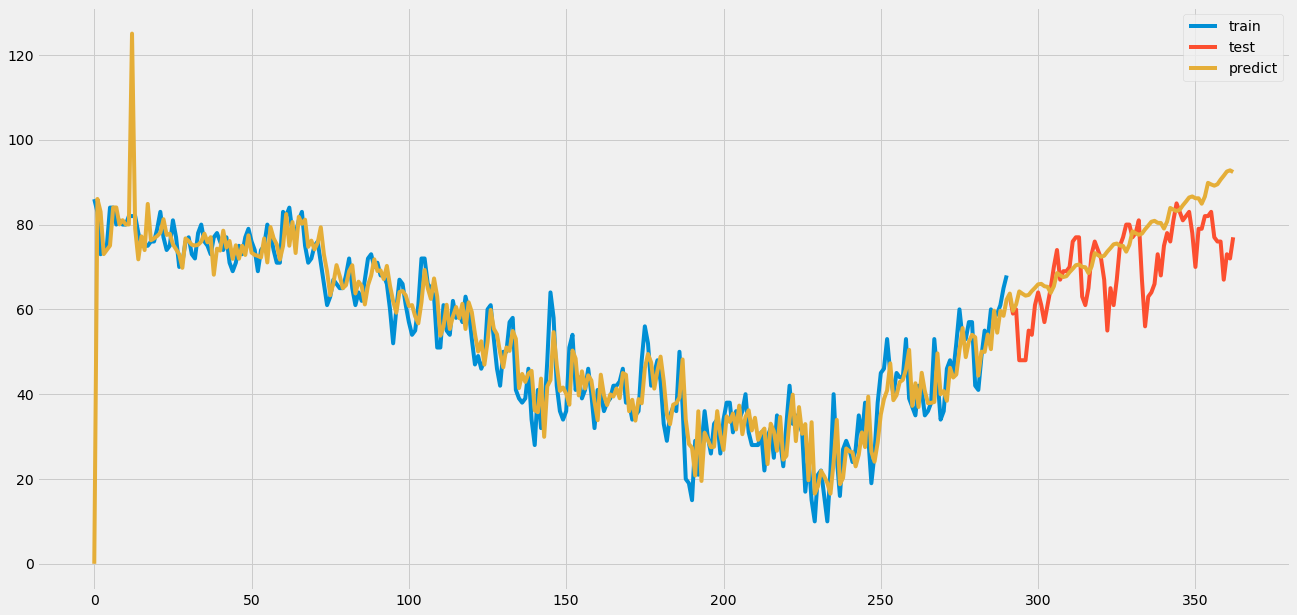

In [4]:
model = ARIMA(analysis=analysis, use_features=False)
analysis.run_model(model, name='ARIMA')

'Train Error (RMSE): 5.642694391866354  Num NaN: 0'

'Test Error (RMSE): 5.578629859661879    Num NaN: 0'

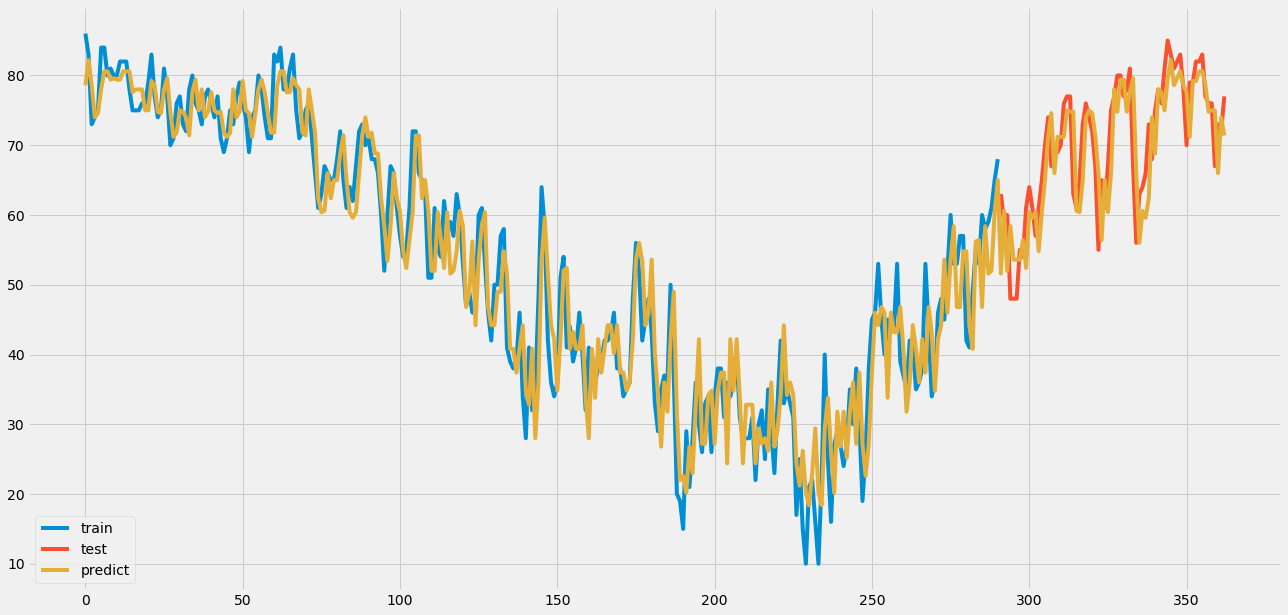

In [5]:
from sklearn.neighbors import KNeighborsRegressor
model = Regressor(analysis=analysis, regressor=KNeighborsRegressor)
analysis.run_model(model, name='KNN')

//anaconda/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


'Train Error (RMSE): 1361240487354.0837  Num NaN: 0'

'Test Error (RMSE): 1720564695620.4224    Num NaN: 0'

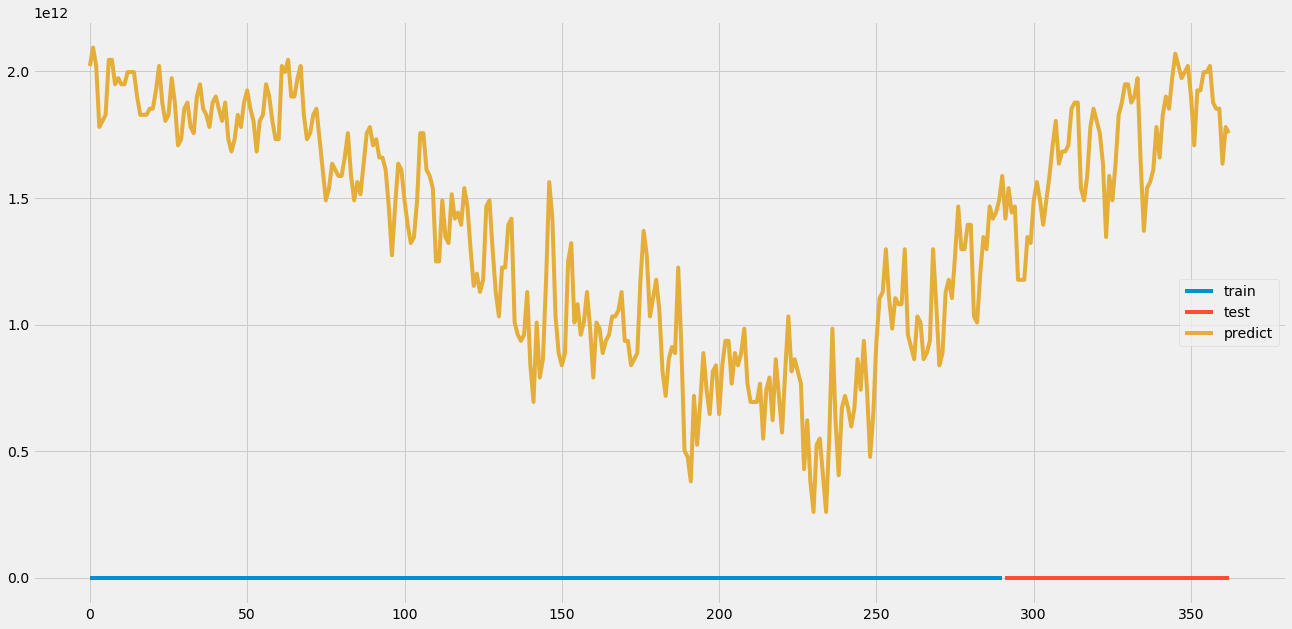

In [6]:
from sklearn.linear_model import SGDRegressor
model = Regressor(analysis=analysis, regressor=SGDRegressor)
analysis.run_model(model, name='SGD')

'Train Error (RMSE): 5.489710627676524  Num NaN: 0'

'Test Error (RMSE): 5.675061135966196    Num NaN: 0'

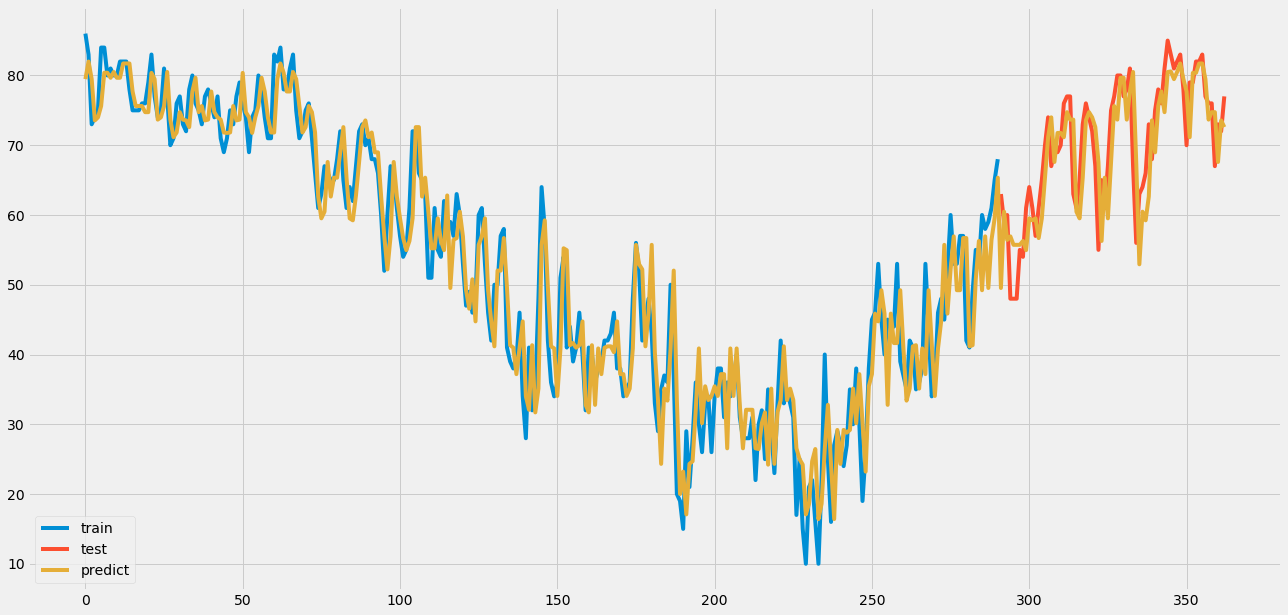

In [7]:
from sklearn.ensemble import RandomForestRegressor
model = Regressor(analysis=analysis, regressor=RandomForestRegressor)
analysis.run_model(model, name='RandomForest')

'Train Error (RMSE): 5.8262593271566585  Num NaN: 0'

'Test Error (RMSE): 5.7544399677418205    Num NaN: 0'

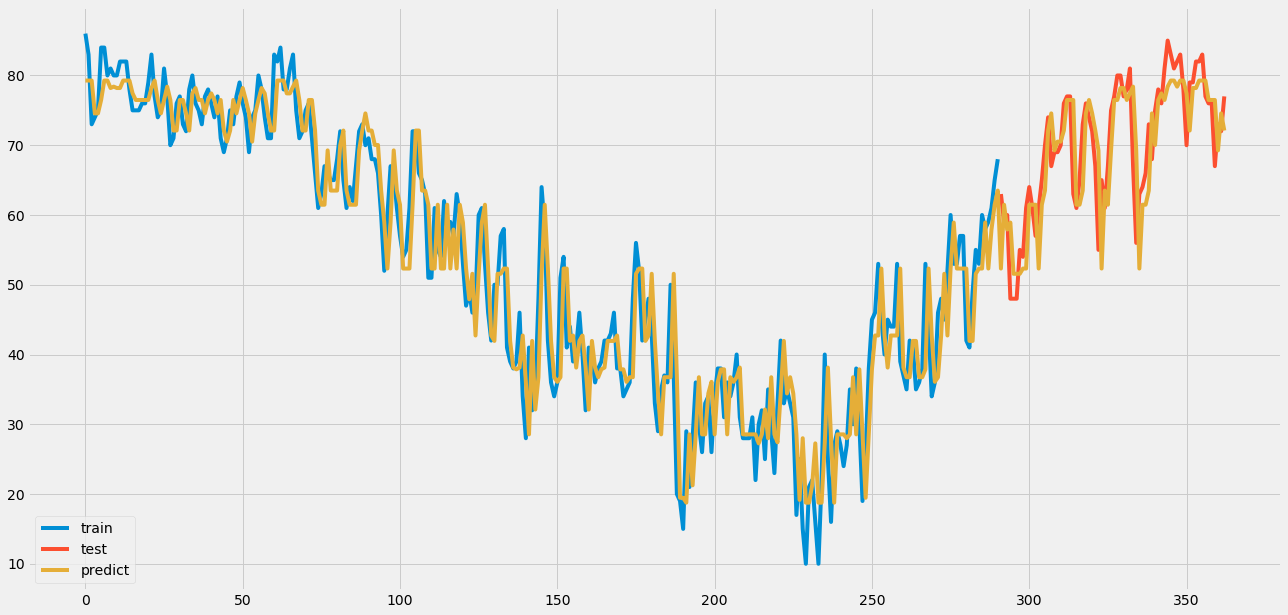

In [8]:
from sklearn.ensemble import AdaBoostRegressor
model = Regressor(analysis=analysis, regressor=AdaBoostRegressor)
analysis.run_model(model, name='AdaBoost')

'Train Error (RMSE): 5.356656808124194  Num NaN: 0'

'Test Error (RMSE): 5.61206919340218    Num NaN: 0'

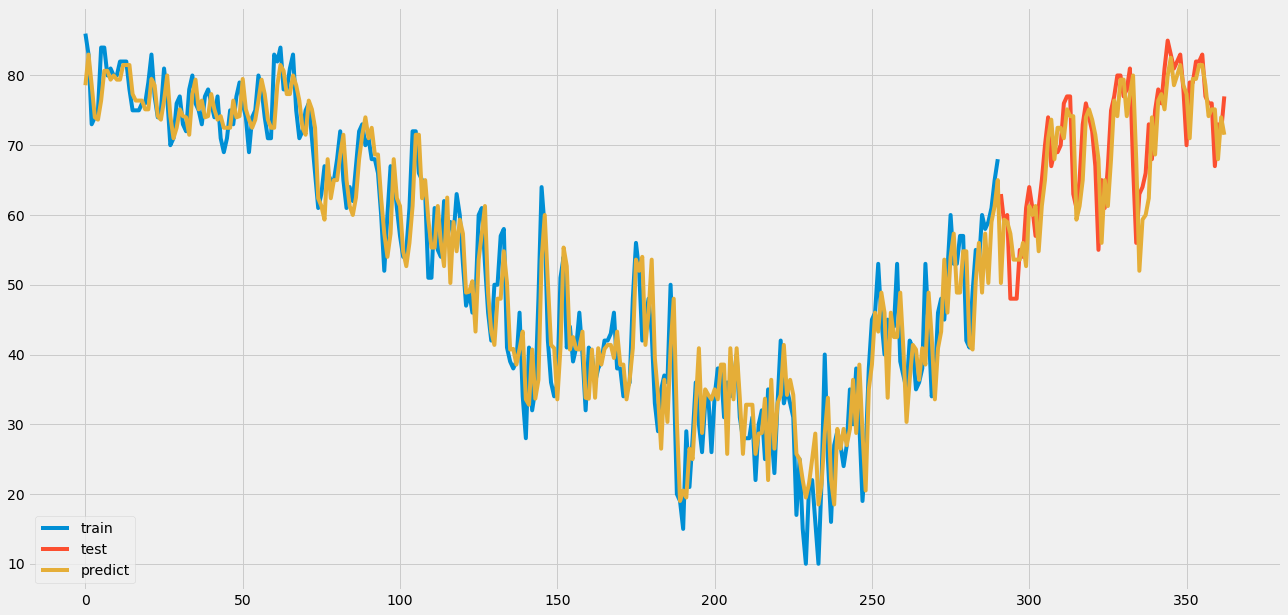

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
model = Regressor(analysis=analysis, regressor=GaussianProcessRegressor)
analysis.run_model(model, name='GaussianProcess')

## Recurrent Neural Network Complete Sequence

Complete sequence means that the entire sequence is input into the network and each timestep produces an output.  There are no batches, just one long sequence.

Using TensorFlow backend.
//anaconda/envs/python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


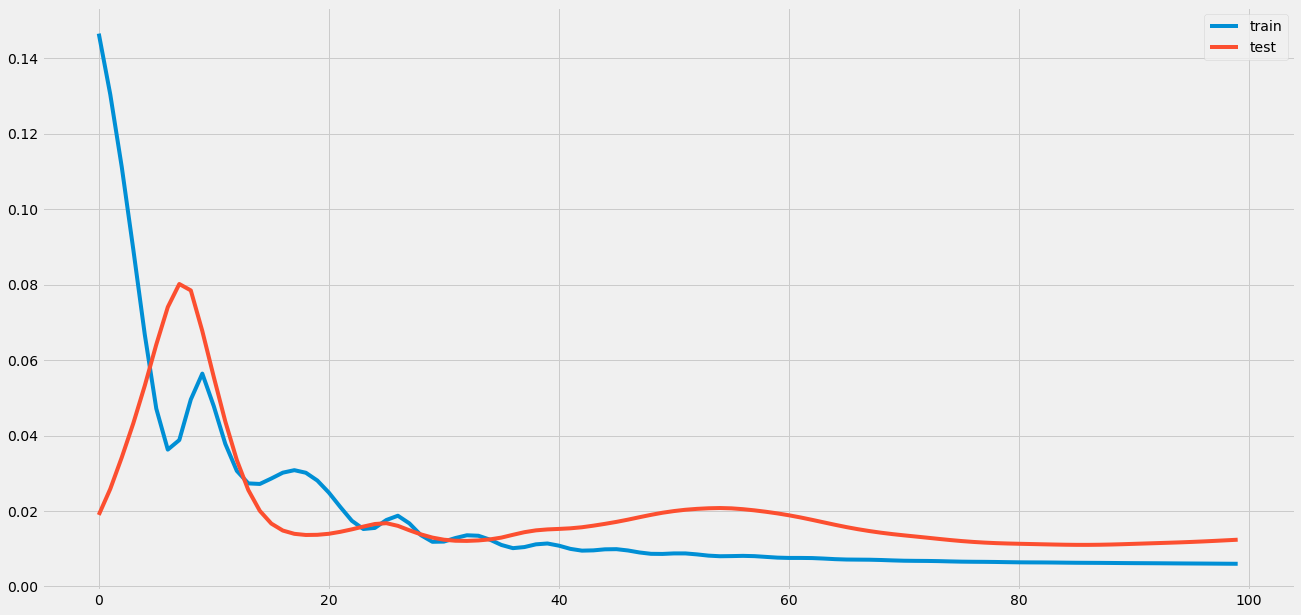

'Train Error (RMSE): 6.658500170336185  Num NaN: 0'

'Test Error (RMSE): 6.4983509521936735    Num NaN: 0'

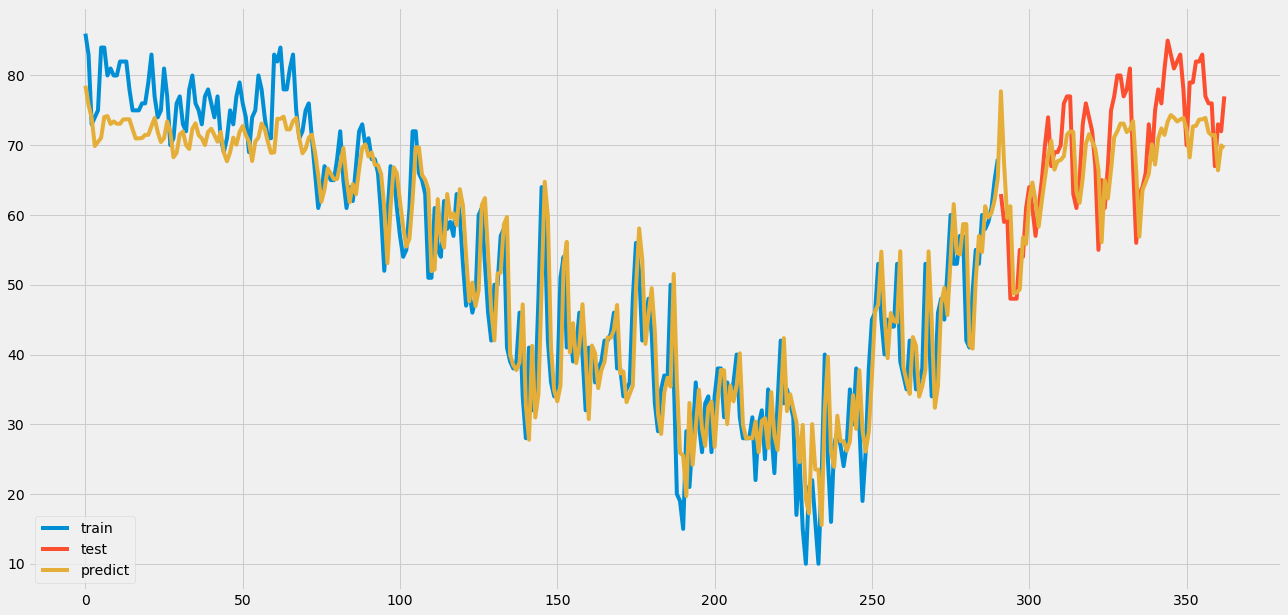

In [10]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

nn = Sequential()
nn.add(layers.SimpleRNN(50, activation='tanh', input_shape=(len(analysis.x_train), NUM_FEATURES), return_sequences=True))

nn.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
nn.add(layers.TimeDistributed(layers.Dense(1, activation='tanh')))
# nn.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))
nn.compile(loss='mse', optimizer='adam')

model = RNNAll(analysis=analysis, model=nn, fit_config={'epochs': 100, 'shuffle': False})
analysis.run_model(model, name='RNNAll')

## Recurrent Neural Network Complete Sequence (LSTM)

Complete sequence means that the entire sequence is input into the network and each timestep produces an output.  There are no batches, just one long sequence.

//anaconda/envs/python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


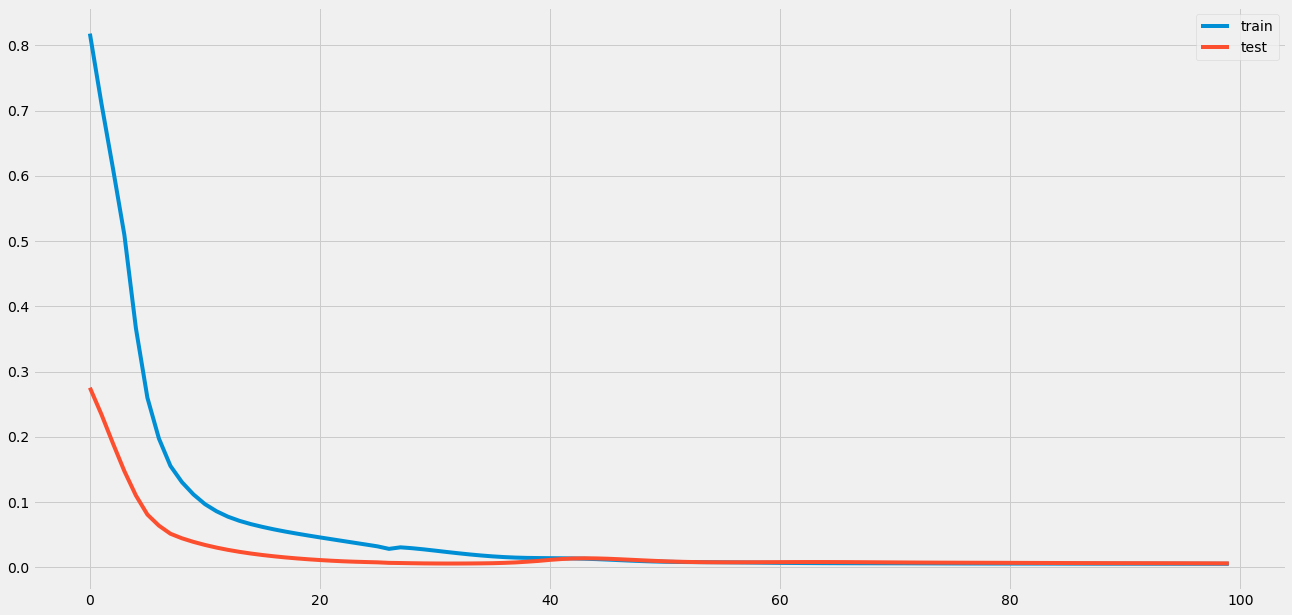

'Train Error (RMSE): 6.224091198949064  Num NaN: 0'

'Test Error (RMSE): 12.13682082115574    Num NaN: 0'

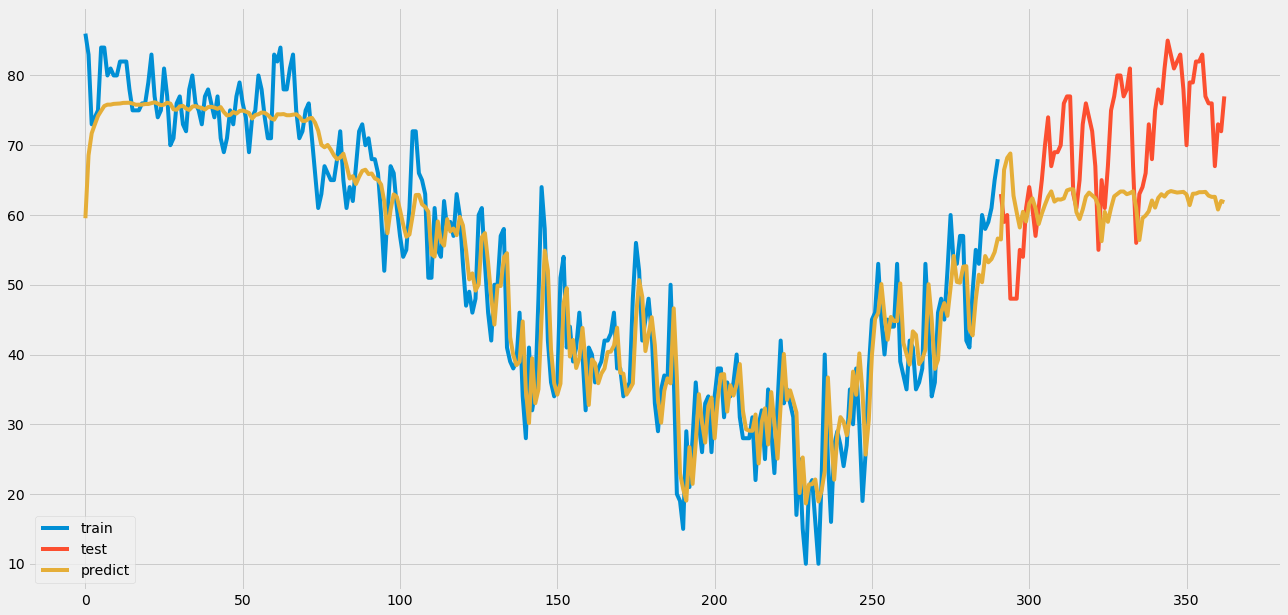

In [11]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

nn = Sequential()
nn.add(layers.LSTM(50, activation='tanh', input_shape=(len(analysis.x_train), NUM_FEATURES), return_sequences=True))

nn.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
nn.add(layers.TimeDistributed(layers.Dense(1, activation='tanh')))
# nn.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))
nn.compile(loss='mse', optimizer='adam')

model = RNNAll(analysis=analysis, model=nn, fit_config={'epochs': 100, 'shuffle': False})
analysis.run_model(model, name='LSTMAll')

# Chunking Data

Now going to use models that require chunking.  We perform chunking by taking the time series:

x = (x0, x1, x2, x3, ...)
y = (x1, x2, x3, x4, ...)

and modifying it such that if the chunk parameter, c, is set to 3:

x = ((x0, x1, x2), (x1, x2, x3), (x2, x3, x4), ...)
y = (x3, x4, x5, ...)

This results in the first c values in not having a prediction and thus (Num NaN is > 0 and == c).



## LinearRegression

'Train Error (RMSE): 5.693423462648144  Num NaN: 4'

'Test Error (RMSE): 5.52364819631106    Num NaN: 4'

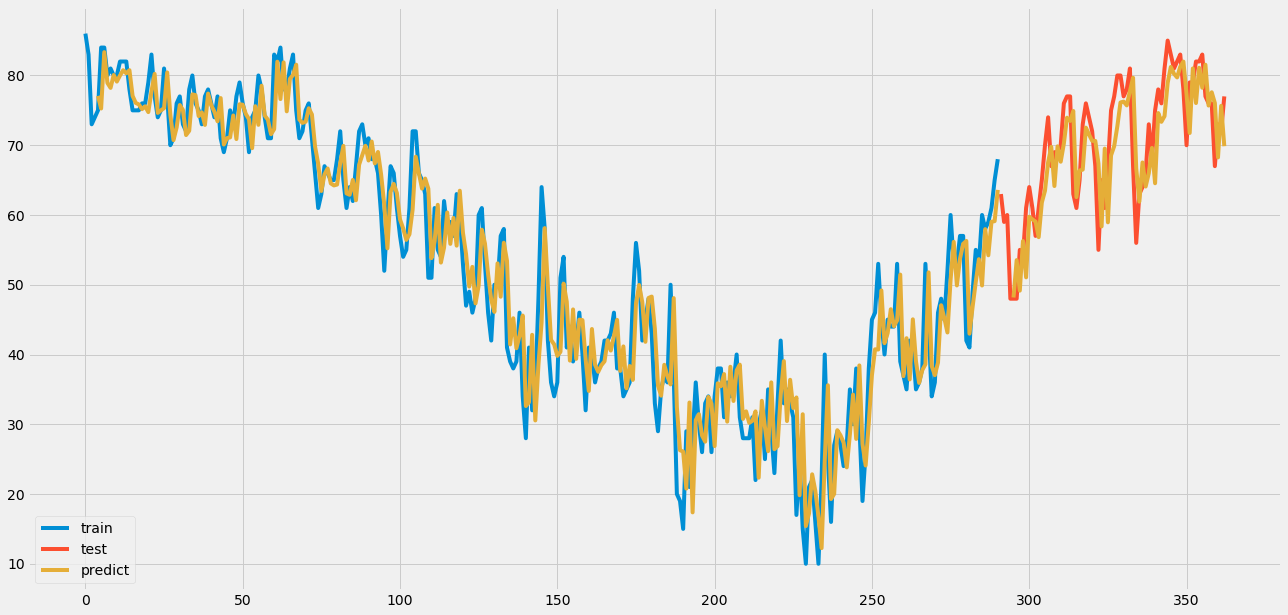

In [12]:
model = LinearRegression(analysis=analysis, num_days=NUM_DAYS)
analysis.run_model(model, name='LinearRegression')

## FeedForward Neural Network

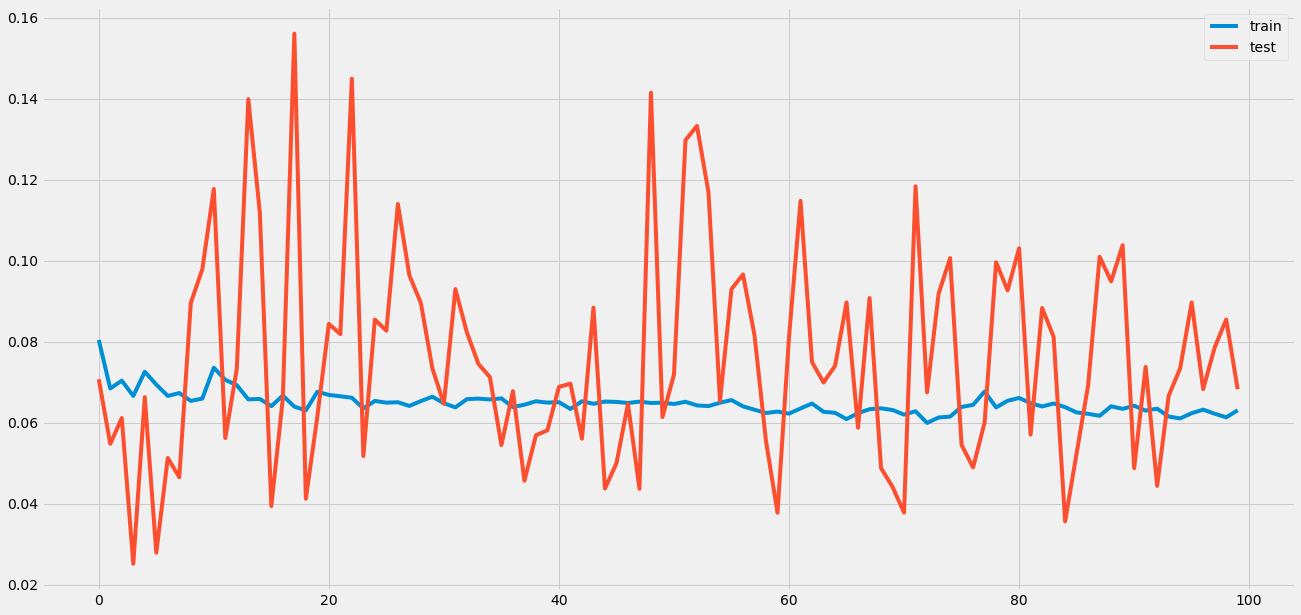

'Train Error (RMSE): 18.4222005350693  Num NaN: 4'

'Test Error (RMSE): 19.590798382098537    Num NaN: 4'

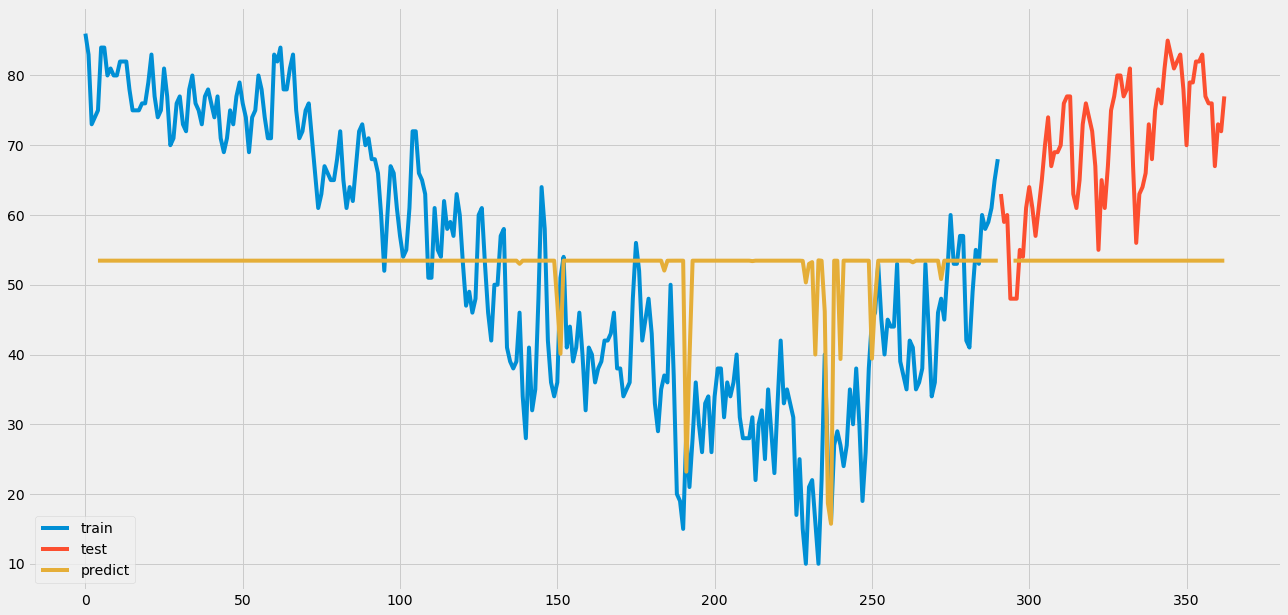

In [13]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

nn = Sequential()
nn.add(layers.Dense(25, activation='tanh',
                    batch_input_shape=(None, NUM_DAYS * NUM_FEATURES)))
nn.add(layers.Dense(10, activation='tanh'))
nn.add(layers.Dense(1, activation='tanh'))
nn.compile(loss='mse', optimizer='sgd')

model = FNN(analysis=analysis, model=nn, num_days=NUM_DAYS)
analysis.run_model(model, name='FNN')


## Recurrent Neural Network with Single Output

Single output means that the chunked timesteps are input and then the final output of the RNN is used as the prediction.

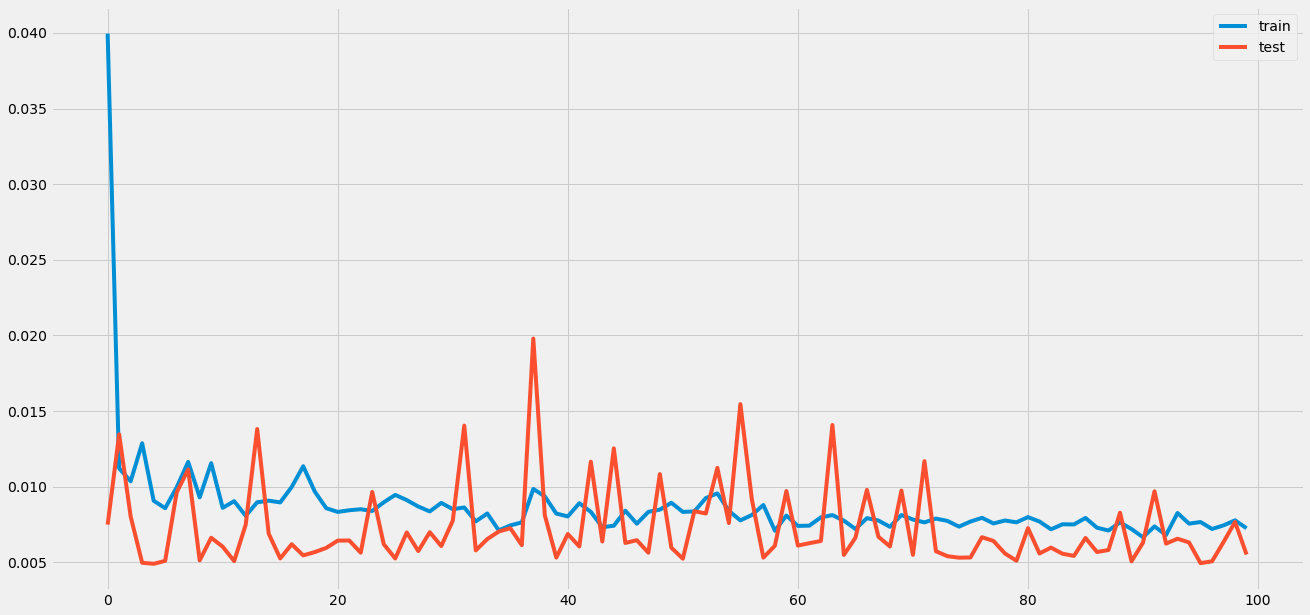

'Train Error (RMSE): 7.21125967180754  Num NaN: 4'

'Test Error (RMSE): 5.5756398148534245    Num NaN: 4'

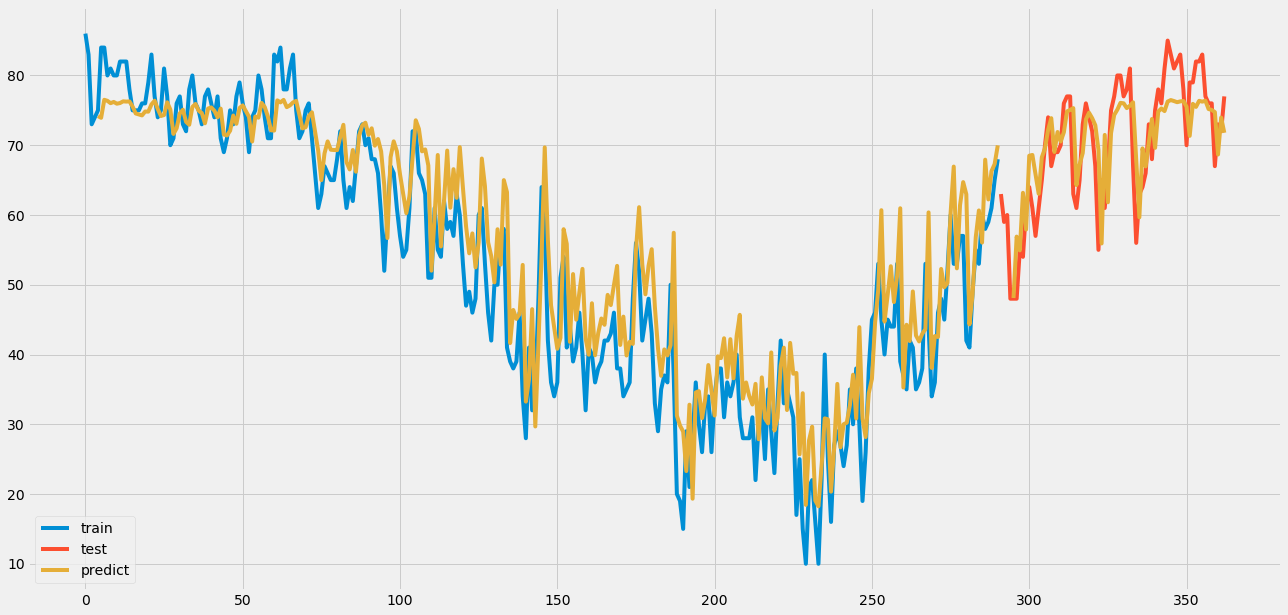

In [14]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

nn = Sequential()
nn.add(layers.SimpleRNN(50, input_shape=(NUM_DAYS, NUM_FEATURES)))

nn.add(layers.Dense(1, activation='tanh'))
nn.add(layers.Dense(1, activation='linear'))
nn.compile(loss='mse', optimizer='adam')
        
model = RNNSingle(analysis=analysis, model=nn, num_days=NUM_DAYS)
analysis.run_model(model, name='RNNSingle')

## Recurrent Neural Network with Multiple Outputs

Multiple outputs means that the chunked data is input and the output at each timestep is used.

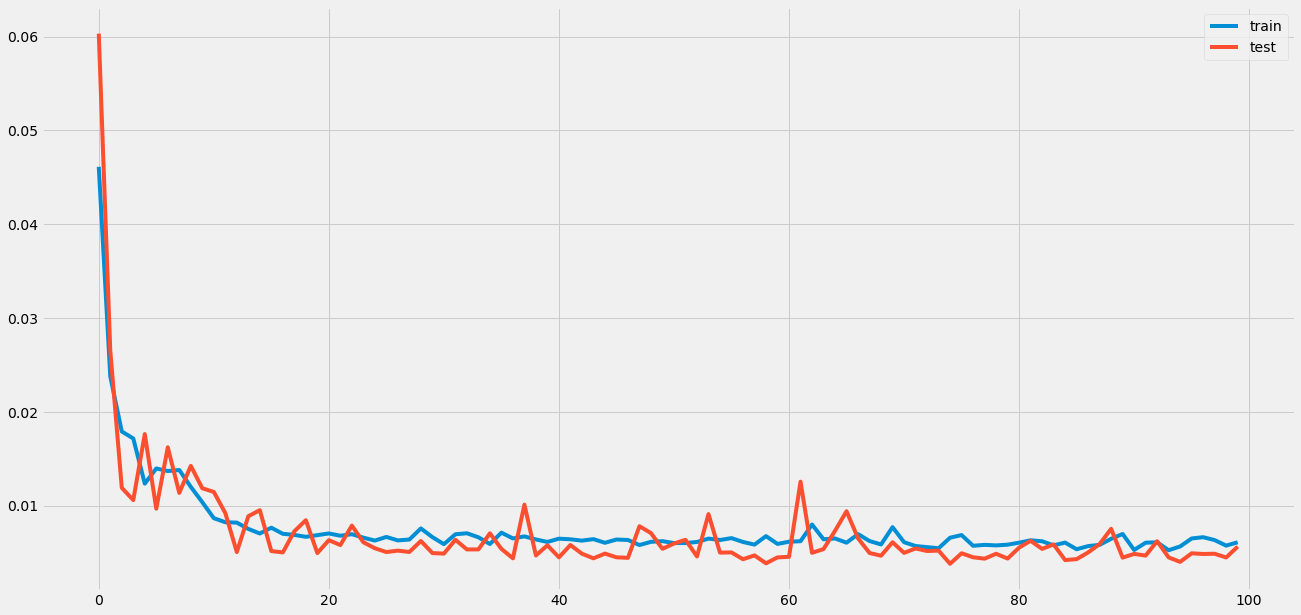

'Train Error (RMSE): 6.632561181331728  Num NaN: 0'

'Test Error (RMSE): 6.505645154436162    Num NaN: 0'

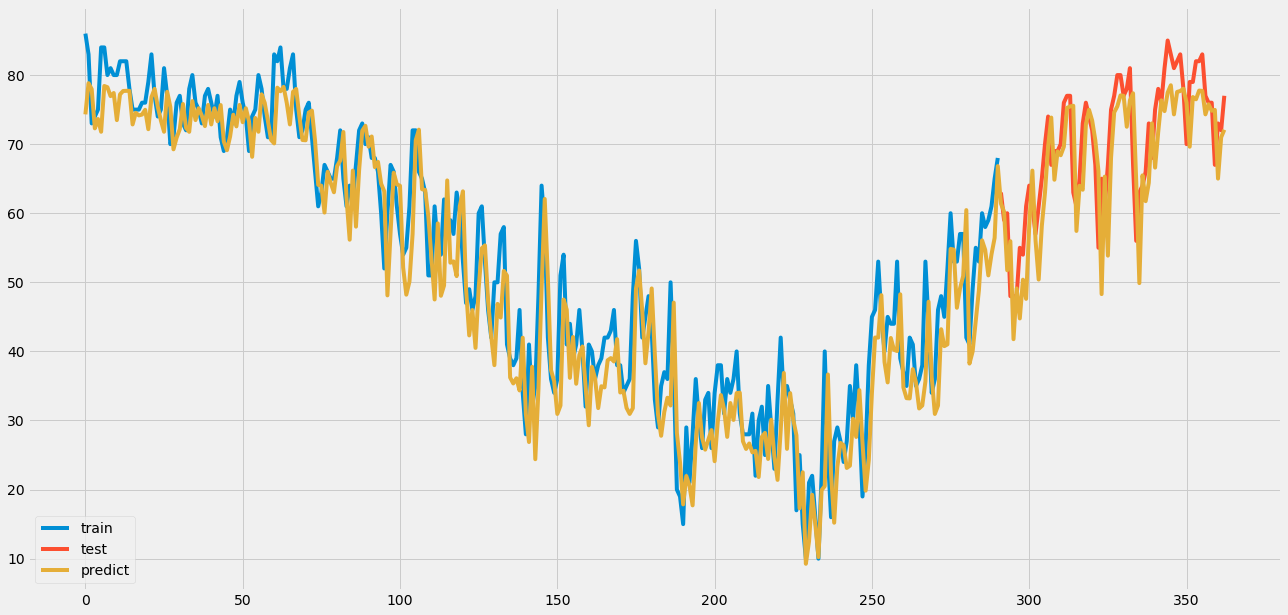

In [15]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

nn = Sequential()
nn.add(layers.SimpleRNN(50, activation='tanh', input_shape=(NUM_DAYS, NUM_FEATURES), return_sequences=True))

nn.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
nn.add(layers.TimeDistributed(layers.Dense(1, activation='tanh')))
# nn.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))
nn.compile(loss='mse', optimizer='adam')

model = RNNMultiple(analysis=analysis, model=nn, num_days=NUM_DAYS)
analysis.run_model(model, name='RNNMultiple')

## Recurrent Neural Network with Single Output (LSTM)

Single output means that the chunked timesteps are input and then the final output of the RNN is used as the prediction.

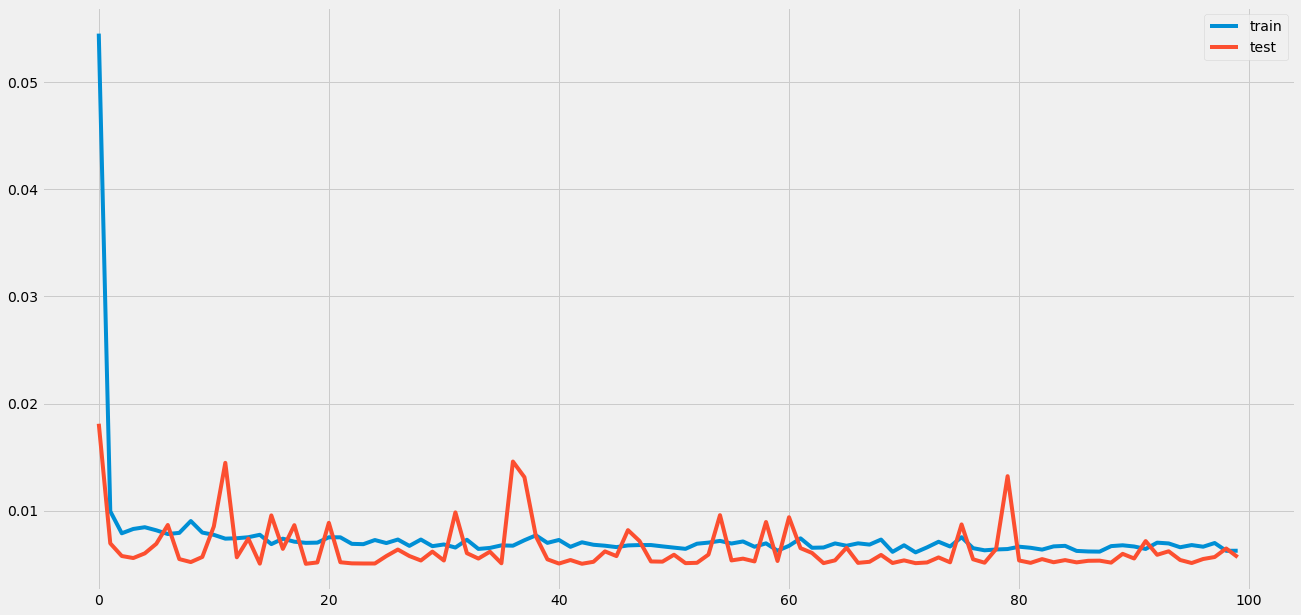

'Train Error (RMSE): 5.470305019410476  Num NaN: 4'

'Test Error (RMSE): 5.652902857946154    Num NaN: 4'

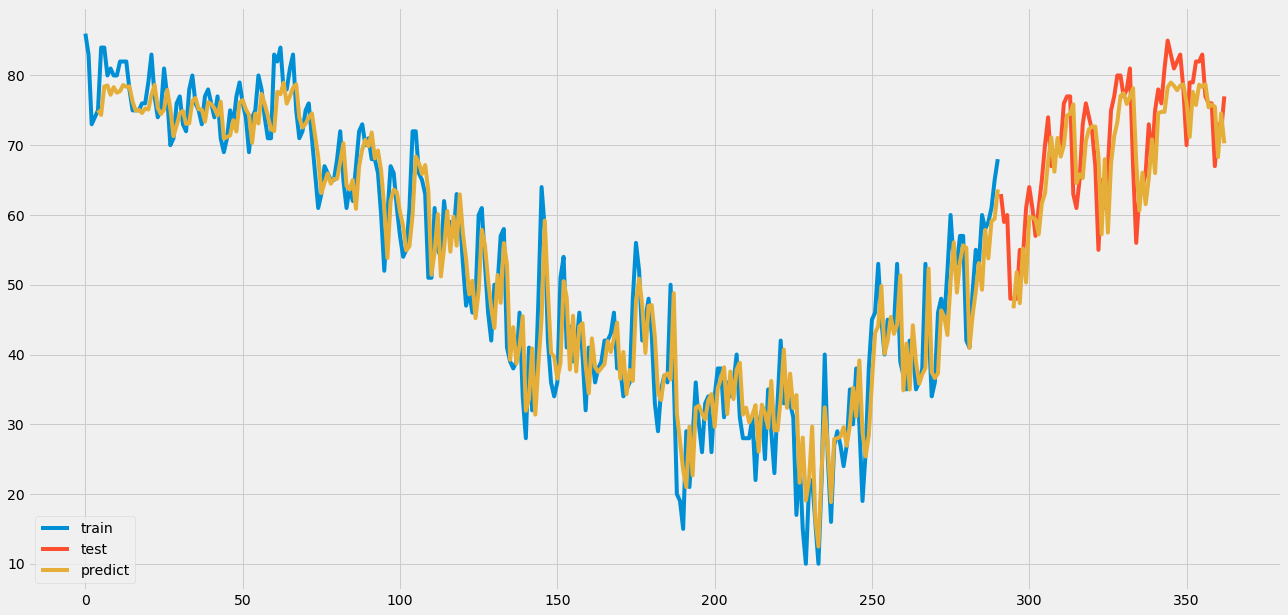

In [16]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

nn = Sequential()
nn.add(layers.LSTM(50, input_shape=(NUM_DAYS, NUM_FEATURES)))

nn.add(layers.Dense(1, activation='tanh'))
nn.add(layers.Dense(1, activation='linear'))
nn.compile(loss='mse', optimizer='adam')
        
model = RNNSingle(analysis=analysis, model=nn, num_days=NUM_DAYS)
analysis.run_model(model, name='LSTMSingle')

## Recurrent Neural Network with Multiple Outputs (LSTM)

Multiple outputs means that the chunked data is input and the output at each timestep is used.

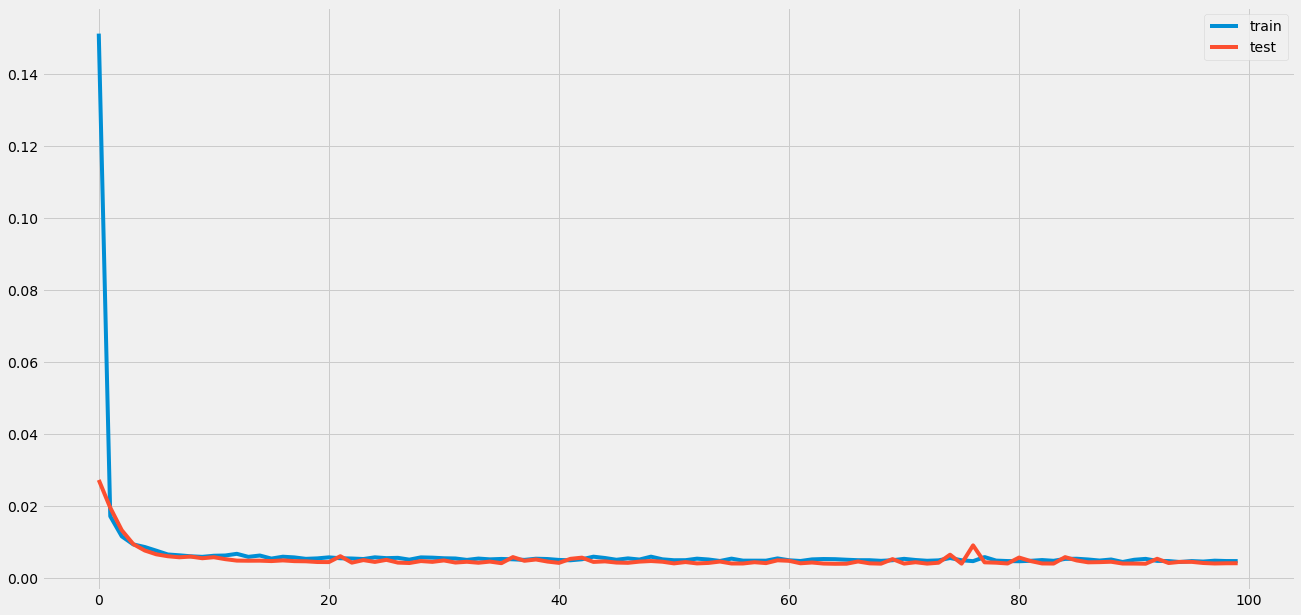

'Train Error (RMSE): 5.5831126847071975  Num NaN: 0'

'Test Error (RMSE): 5.628425575194939    Num NaN: 0'

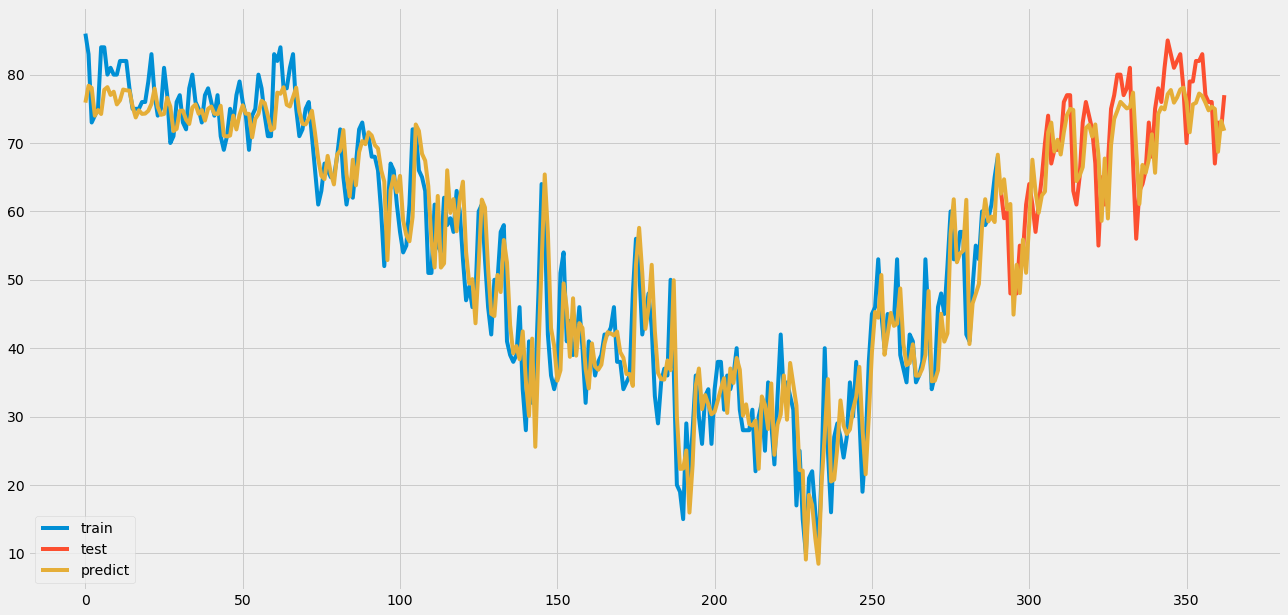

In [17]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

nn = Sequential()
nn.add(layers.LSTM(50, activation='tanh', input_shape=(NUM_DAYS, NUM_FEATURES), return_sequences=True))

nn.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
nn.add(layers.TimeDistributed(layers.Dense(1, activation='tanh')))
# nn.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))
nn.compile(loss='mse', optimizer='adam')

model = RNNMultiple(analysis=analysis, model=nn, num_days=NUM_DAYS)
analysis.run_model(model, name='LSTMMultiple')